# Step 1: Predict Target Protein Structure with `ESMFold`

### RORc Nuclear Receptor Agonist Case-Study
Rene, O.; *et al*. "[Minor Structural Change to Tertiary Sulfonamide RORc Ligands Led to Opposite Mechanisms of Action.](https://pubs.acs.org/doi/10.1021/ml500420y)" *ACS Med. Chem. Lett.* **2015**, *6*, 276-281.

**Abstract:** A minor structural change to tertiary sulfonamide RORc ligands led to distinct mechanisms of action. Co-crystal structures of two compounds revealed mechanistically consistent protein conformational changes. Optimized phenylsulfonamides were identified as RORc agonists while benzylsulfonamides exhibited potent inverse agonist activity. Compounds behaving as agonists in our biochemical assay also gave rise to an increased production of IL-17 in human PBMCs whereas inverse agonists led to significant suppression of IL-17 under the same assay conditions. The most potent inverse agonist compound showed >180-fold selectivity over the ROR isoforms as well as all other nuclear receptors that were profiled.

**Note:** Although we already have the crystal structure of the protein-ligand complex [PDB: 4WQP](https://www.rcsb.org/structure/4WQP), we will still use [ESMFold](https://www.science.org/doi/10.1126/science.ade2574) to predict the protein structure for demonstration purposes.

https://pubs.acs.org/cms/10.1021/amclct.2015.6.issue-3/asset/amclct.2015.6.issue-3.xlargecover.jpg

## Protein Sequence for RORc

[UNIPROT ID P51449, RORG_HUMAN](https://www.uniprot.org/uniprotkb/P51449/entry):

```
>4WQP_1, Nuclear receptor ROR-gamma, Homo sapiens
MHHHHHHGENLYFQGSAPYASLTEIEHLVQSVCKSYRETCQLRLEDLLRQRSNIFSREEVTGYQRKSMWEMWERCAHHLTEAIQYVVEFAKRLSGFMELCQN
DQIVLLKAGAMEVVLVRMCRAYNADNRTVFFEGKYGGMELFRALGCSELISSIFDFSHSLSALHFSEDEIALYTALVLINAHRPGLQEKRKVEQLQYNLELA
FHHHLCKTHRQSILAKLPPKGKLRSLCSQHVERLQIFQHLHPIVVQAAFPPLYKELFSGNS
```


## 1.1 Set Up the Environment

In [1]:
!pip install pandas numpy matplotlib loguru py3dmol

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 4.2 MB/s eta 0:00:00


In [3]:
import os, shutil
from google.colab import userdata
import requests
import py3Dmol

## 1.2 Set Up `output` Directory

In [4]:
def prepare_output_directory(output):
    """
    Prepare the output directory
    output: str, the output directory
    return: None
    """
    # overwrite the output directory
    if os.path.exists(output):
        shutil.rmtree(output)
    os.makedirs(output)

In [5]:
output_dir = "/content/output/esmfold_result"
prepare_output_directory(output_dir)

## 1.3 Set Up URL and `API_KEY`

NOTE: Be sure to follow the steps in the [README](https://github.com/bf-nv/bionemo_tutorials/blob/main/README.md) to embed your NVIDIA `API_KEY` into your Google Colab environment.

In [6]:
invoke_url = "https://health.api.nvidia.com/v1/biology/nvidia/esmfold"

API_KEY = userdata.get('API_KEY')
headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Accept": "application/json",
}

## 1.4 Use `ESMFold` to Predict the Protein Structure

In [7]:
# sequence of the protein
sequence = "MHHHHHHGENLYFQGSAPYASLTEIEHLVQSVCKSYRETCQLRLEDLLRQRSNIFSREEVTGYQRKSMWEMWERCAHHLTEAIQYVVEFAKRLSGFMELCQNDQIVLLKAGAMEVVLVRMCRAYNADNRTVFFEGKYGGMELFRALGCSELISSIFDFSHSLSALHFSEDEIALYTALVLINAHRPGLQEKRKVEQLQYNLELAFHHHLCKTHRQSILAKLPPKGKLRSLCSQHVERLQIFQHLHPIVVQAAFPPLYKELFSGNS"

print(f"length of protein: {len(sequence)} aa")

length of protein: 265 aa


In [8]:
payload = {
  "sequence": sequence
}

# initiate a session to re-use connections
session = requests.Session()
response = session.post(invoke_url, headers=headers, json=payload)
response.raise_for_status()
result = response.json()

## 1.5 Save the Result

In [9]:
result.keys()

dict_keys(['pdbs'])

In [10]:
# only 1 sequence is allowed each time
assert len(result["pdbs"]) == 1

# Write PDB file
fp = os.path.join(output_dir, f"predicted_protein.pdb")
with open(fp, "w") as f:
    f.write(result["pdbs"][0]) # the str representation of the PDB file

In [11]:
# Download the predicted protein PDB file, which needs to be uploaded in Step 3 DiffDock inference
from google.colab import files
pred_pdb_file = '/content/output/esmfold_result/predicted_protein.pdb'
files.download(pred_pdb_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 1.6 Visualize the Result

We can examine the predicted protein structure along with its pLDDT confidence scores. These scores are stored in the B-factor field of the returned structure data.

To maintain consistency with the [EBI/AlphaFold Database](https://alphafold.ebi.ac.uk/), we’ll use pLDDT scores to indicate confidence in the predicted protein structure. These scores will be visualized using `py3Dmol`, with color coding to highlight regions of varying reliability.

<DIV style="width: 600px;">
<IMG src="https://res.cloudinary.com/dpfqlyh21/image/upload/v1705026011/obsidian/izrfmiepbzpnzm2aoqwh.png">
</DIV>




In [12]:
def load_protein(pdb_file_path, width=800, height=600):

    """
    Load a protein structure from a PDB file and display it using py3Dmol.
    pdb_file_path: str, path to the PDB file
    width: int, width of the viewer in pixels
    height: int, height of the viewer in pixels
    return: py3Dmol.view object
    """

    with open(pdb_file_path) as ifile:
        pdb_data = "".join([x for x in ifile])

    view = py3Dmol.view(width=width, height=height)
    view.addModelsAsFrames(pdb_data)

    for line in pdb_data.split("\n"):
        split = line.split()
        if len(split) == 0 or split[0] != "ATOM":
            continue
        # Assuming the B-factor is at position 10 (you may need to adjust this based on your PDB format)
        b_factor = float(split[10])
        if b_factor > 90:
            color = "blue"
        elif 70 <= b_factor <= 90:
            color = "cyan"
        elif 50 <= b_factor < 70:
            color = "yellow"
        else:
            color = "orange"

        # Atom serial numbers typically start from 1, hence idx should be used directly
        idx = int(split[1])

        # Style should be set per atom id
        view.setStyle({'model': -1, 'serial': idx}, {"cartoon": {'color': color}})
    view.zoomTo()
    return view

In [13]:
view = load_protein(
    pdb_file_path = '/content/output/esmfold_result/predicted_protein.pdb',
    width=800,
    height=500
)
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## 1.7 Visualize the Superimposed Structure

To demonstrate how the `ESMFold` predicted structure aligns with the experimentally determined one, we’ll use the X-ray crystal structure from the RCSB Protein Data Bank, [PDB: 4WQP](https://www.rcsb.org/structure/4WQP).

### Establish the `PyMOL` Environment for Structure Alignment

`PyMOL` will be used to align the `ESMFold` predicted protein structure with the ground truth PDB file.

1) Install `PyMOL` in your Google Colab environment.

2) Verify the installation by following the tutorial provided here: https://github.com/MooersLab/colabOpenSourcePyMOLpySnips?tab=readme-ov-file.



In [14]:
from IPython.utils import io
import tqdm.notebook
import os
"""The PyMOL installation is done inside two nested context managers. This approach
was inspired by Dr. Christopher Schlick's (of the Phenix group at
Lawrence Berkeley National Laboratory) method for installing cctbx
in a Colab Notebook. He presented his work on September 1, 2021 at the IUCr
Crystallographic Computing School. Blaine Mooers adapted Chris's approach here. This revised
approach was presentated at the SciPy2021 conference in July 2021 and published in the
[proceedings](http://conference.scipy.org/proceedings/scipy2021/blaine_mooers.html).
The new approach is easier for beginners to use. The old approach is easier to debug
and could be used as a back-up approach.

Thank you to Professor David Oppenheimer of the University of Florida for suggesting the use mamba and of Open Source PyMOL.
"""
total = 100
with tqdm.notebook.tqdm(total=total) as pbar:
    with io.capture_output() as captured:

        !pip install -q condacolab
        import condacolab
        condacolab.install()
        pbar.update(10)

        import sys
        sys.path.append('/usr/local/lib/python3.10/site-packages/')
        pbar.update(20)

        # Install PyMOL
        %shell mamba install pymol-open-source --yes

        pbar.update(100)

  0%|          | 0/100 [00:00<?, ?it/s]

### Code below tests if `PyMol` installation was successful

If the test failed, try to run the installation cell above again

--2025-05-23 21:34:26--  https://raw.githubusercontent.com/bf-nv/bionemo_tutorials/refs/heads/main/4wqp_monomer.pdb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311770 (304K) [text/plain]
Saving to: ‘4wqp_monomer.pdb’

4wqp_monomer.pdb    100%[===================>] 304.46K  --.-KB/s    in 0.04s   

2025-05-23 21:34:27 (6.87 MB/s) - ‘4wqp_monomer.pdb’ saved [311770/311770]



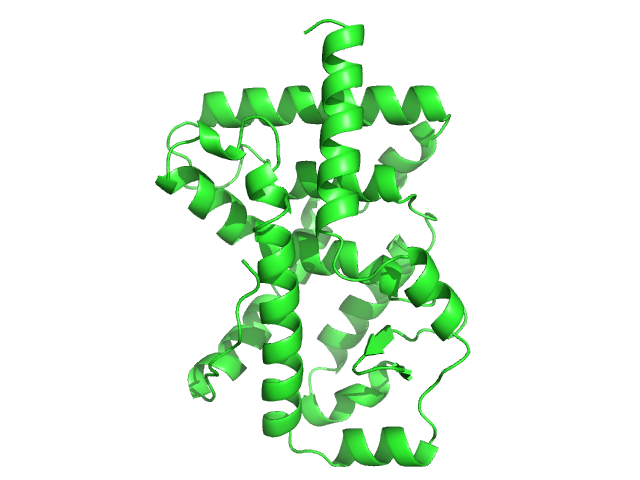

In [1]:
from pymol import cmd
from IPython.display import Image

# download the ground truth pdb "4wqp_monomer.pdb"
!wget https://raw.githubusercontent.com/bf-nv/bionemo_tutorials/refs/heads/main/4wqp_monomer.pdb

true_pdb_file = '/content/4wqp_monomer.pdb' # true crystal structure

def truncate_string(input_string):
    # Find the last occurrence of '/'
    last_slash_index = input_string.rfind('/')
    return input_string[last_slash_index + 1:]

# Using local PDB file since 4WQP is a dimer in RCSB, but we need the monomer
# Load the local PDB file
cmd.load(true_pdb_file)
obj_name = truncate_string(true_pdb_file).split(".")[0]
cmd.orient(obj_name)
cmd.set_view((-0.292365283,    0.898809373,    0.326595277,
               0.506281018,   -0.144253701,    0.850216091,
               0.811294436,    0.413922817,   -0.412875712,
               0.000079364,   -0.000037231, -176.867355347,
              19.699285507,  -33.096054077,    0.763063431,
             139.444869995,  214.293136597,  -20.000000000 ))
cmd.png("test.png")
Image(filename="test.png", unconfined=True)

In [2]:
import py3Dmol
from pymol import cmd
import os

def align_protein(pred_pdb_file, true_pdb_file, output_dir, pred_color = 'cyan', true_color = 'green', width=800, height=600):
    """
    Align two protein structures and display them using py3Dmol.
    pred_pdb_file: str, path to the PDB file of the predicted protein
    true_pdb_file: str, path to the PDB file of the true protein
    output_dir: str, path to the output directory to save the aligned PDB files
    pred_color: str, color of the predicted protein in the viewer
    true_color: str, color of the true protein in the viewer
    width: int, width of the viewer in pixels
    height: int, height of the viewer in pixels
    return: py3Dmol.view object
    """

    # always reinitialize!
    cmd.reinitialize()

    cmd.load(pred_pdb_file, 'predicted_protein')
    cmd.load(true_pdb_file, 'true_protein')

    # Align the structures on the backbone atoms
    cmd.align('predicted_protein & backbone', 'true_protein & backbone', quiet=0)

    # Save the aligned structures
    pred_aligned_fp = os.path.join(output_dir, 'aligned_predicted_protein.pdb')
    true_aligned_fp = os.path.join(output_dir, 'aligned_true_protein.pdb')
    cmd.save(pred_aligned_fp, 'predicted_protein')
    cmd.save(true_aligned_fp, 'true_protein')

    # Read PDB files into strings (assuming they are in the current directory)
    with open(pred_aligned_fp, 'r') as file:
        pred_pdb_data = file.read()

    with open(true_aligned_fp, 'r') as file:
        true_pdb_data = file.read()

    # Create a py3Dmol view
    view = py3Dmol.view(width=width, height=height)

    # Add the predicted protein model
    view.addModel(pred_pdb_data, 'pdb')
    # Set a specific color for the predicted protein, e.g., green
    view.setStyle({'model': 0}, {'cartoon': {'color': pred_color}})

    # Add the true protein model
    view.addModel(true_pdb_data, 'pdb')
    # Set a different specific color for the true protein, e.g., blue
    view.setStyle({'model': 1}, {'cartoon': {'color': true_color}})

    view.zoomTo()
    return view

### Visualize the Results

In [5]:
view = align_protein(
    pred_pdb_file = '/content/output/esmfold_result/predicted_protein.pdb', # prediction
    true_pdb_file = '/content/4wqp_monomer.pdb', # true crystal structure
    output_dir = '/content/output/esmfold_result', # output directory to store the aligned poses so that py3dmol can load back
    pred_color = 'cyan', # color for the predicted structure
    true_color = 'green', # color for the true structure
    width=800,
    height=500
)
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.